## Import data and libraries

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, BatchNormalization, LSTM, Activation, Input
from tensorflow.keras.activations import swish
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import warnings
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [79]:
df_master = pd.read_csv("../data/Train.csv")
df = df_master.copy()
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [80]:
df.shape

(2154048, 19)

## EDA

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


In [82]:
round(df.isna().sum().sort_values(ascending=False) / len(df), 4) * 100

ZONE2             93.65
ZONE1             92.12
TIGO              59.89
DATA_VOLUME       49.23
FREQ_TOP_PACK     41.90
TOP_PACK          41.90
ORANGE            41.56
REGION            39.43
ON_NET            36.52
MONTANT           35.13
FREQUENCE_RECH    35.13
REVENUE           33.71
ARPU_SEGMENT      33.71
FREQUENCE         33.71
REGULARITY         0.00
user_id            0.00
MRG                0.00
TENURE             0.00
CHURN              0.00
dtype: float64

In [83]:
df.TOP_PACK.unique()

array(['On net 200F=Unlimited _call24H', nan, 'On-net 1000F=10MilF;10d',
       'Data:1000F=5GB,7d', 'Mixt 250F=Unlimited_call24H',
       'MIXT:500F= 2500F on net _2500F off net;2d',
       'All-net 500F=2000F;5d', 'On-net 500F_FNF;3d',
       'Data: 100 F=40MB,24H', 'MIXT: 200mnoff net _unl on net _5Go;30d',
       'Jokko_Daily', 'Data: 200 F=100MB,24H', 'Data:490F=1GB,7d',
       'Twter_U2opia_Daily', 'On-net 500=4000,10d', 'Data:1000F=2GB,30d',
       'IVR Echat_Daily_50F', 'Pilot_Youth4_490',
       'All-net 500F =2000F_AllNet_Unlimited', 'Twter_U2opia_Weekly',
       'Data:200F=Unlimited,24H', 'On-net 200F=60mn;1d',
       'All-net 600F= 3000F ;5d', 'Pilot_Youth1_290',
       'All-net 1000F=(3000F On+3000F Off);5d', 'VAS(IVR_Radio_Daily)',
       'Data:3000F=10GB,30d', 'All-net 1000=5000;5d',
       'Twter_U2opia_Monthly', 'MIXT: 390F=04HOn-net_400SMS_400 Mo;4h\t',
       'FNF2 ( JAPPANTE)', 'Yewouleen_PKG', 'Data:150F=SPPackage1,24H',
       'WIFI_Family_2MBPS', 'Data:500F=2GB,2

In [84]:
df.REGION.unique() 

array(['FATICK', nan, 'DAKAR', 'LOUGA', 'TAMBACOUNDA', 'KAOLACK', 'THIES',
       'SAINT-LOUIS', 'KOLDA', 'KAFFRINE', 'DIOURBEL', 'ZIGUINCHOR',
       'MATAM', 'SEDHIOU', 'KEDOUGOU'], dtype=object)

In [85]:
df.MRG.unique()

array(['NO'], dtype=object)

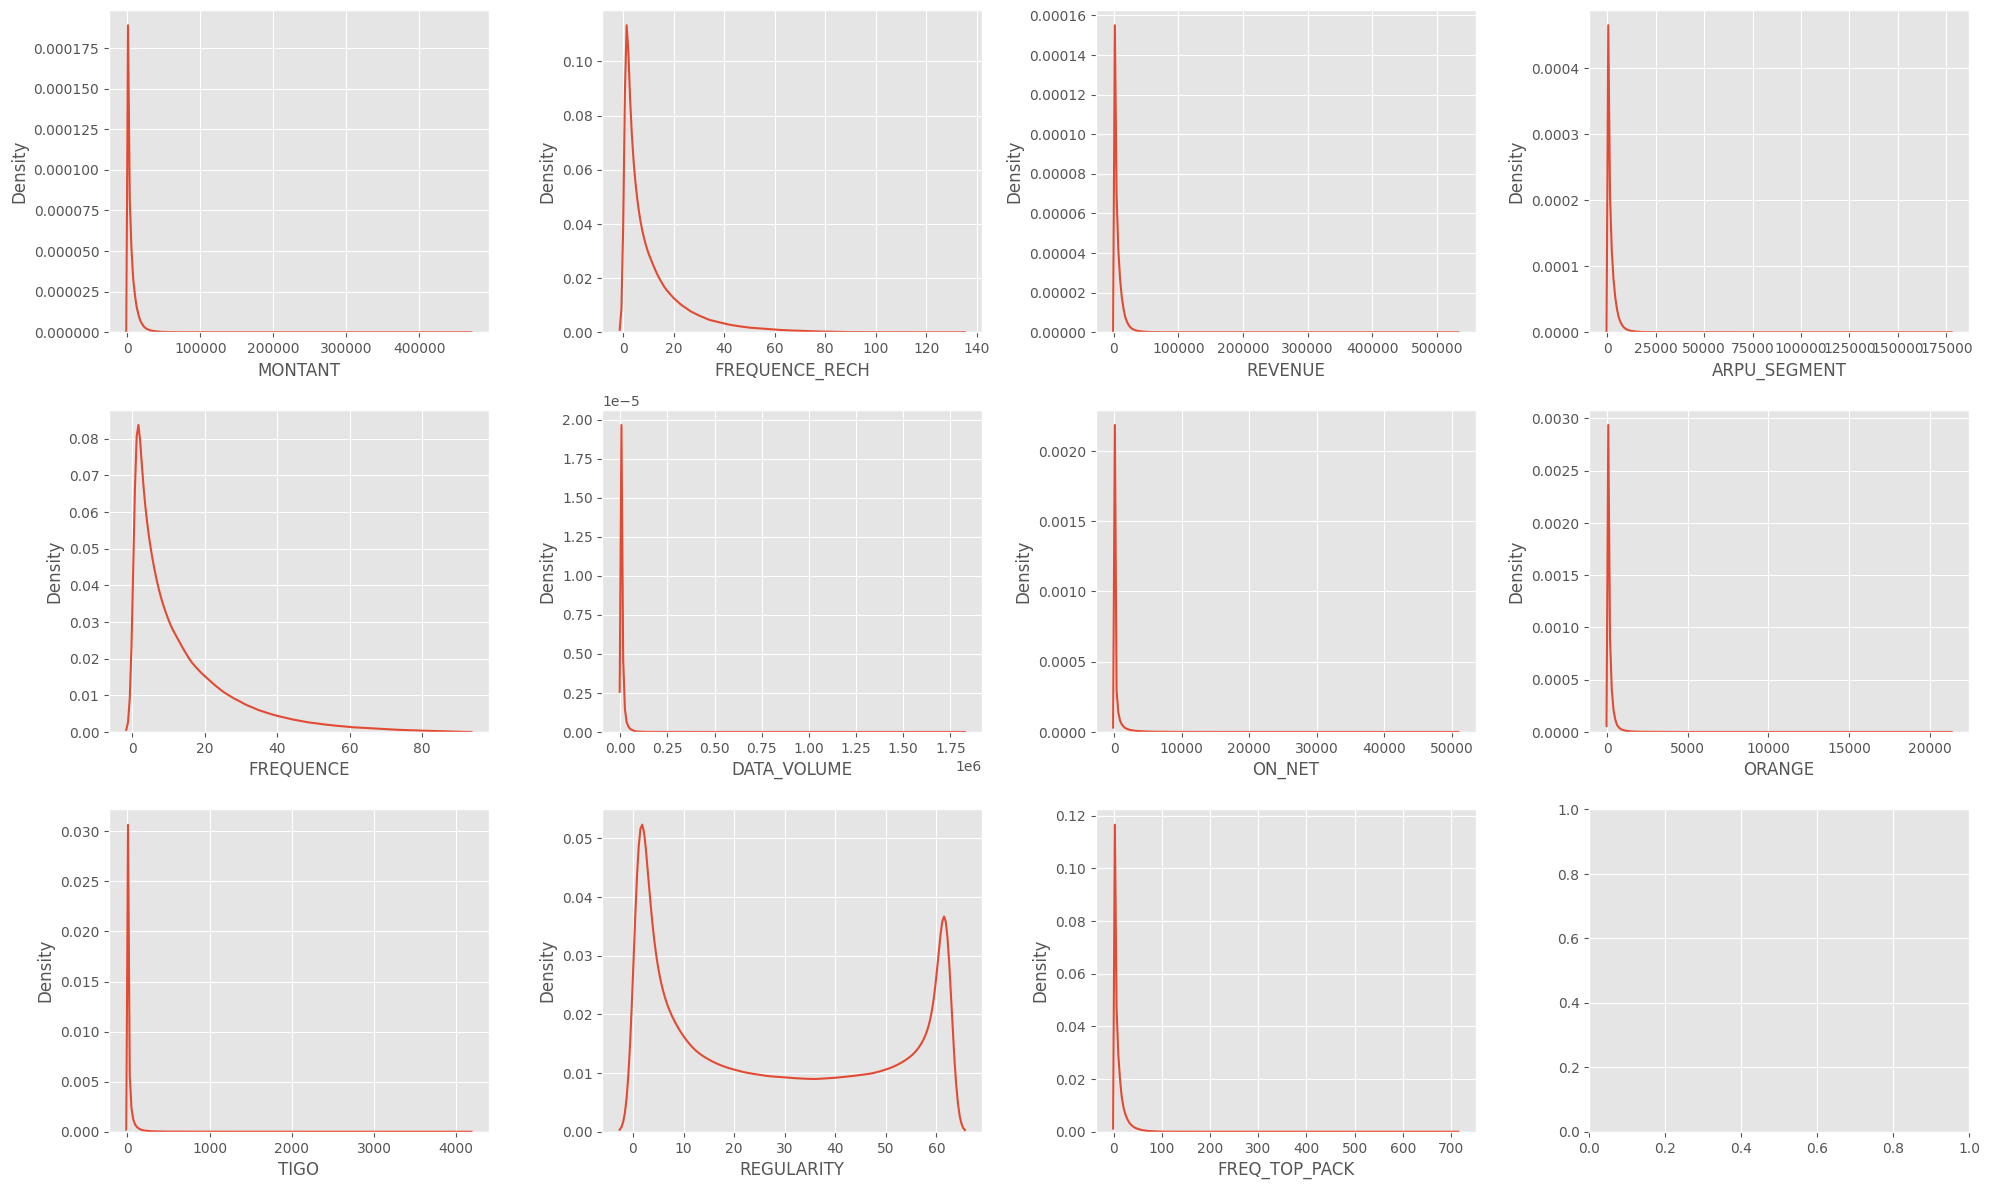

In [86]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

sns.kdeplot(data=df, x="MONTANT", ax=axes[0, 0])
sns.kdeplot(data=df, x="FREQUENCE_RECH", ax=axes[0, 1])
sns.kdeplot(data=df, x="REVENUE", ax=axes[0, 2])
sns.kdeplot(data=df, x="ARPU_SEGMENT", ax=axes[0, 3])

sns.kdeplot(data=df, x="FREQUENCE", ax=axes[1, 0])
sns.kdeplot(data=df, x="DATA_VOLUME", ax=axes[1, 1])
sns.kdeplot(data=df, x="ON_NET", ax=axes[1, 2])
sns.kdeplot(data=df, x="ORANGE", ax=axes[1, 3])

sns.kdeplot(data=df, x="TIGO", ax=axes[2, 0])
sns.kdeplot(data=df, x="REGULARITY", ax=axes[2, 1])
sns.kdeplot(data=df, x="FREQ_TOP_PACK", ax=axes[2, 2])

plt.tight_layout()
plt.show()

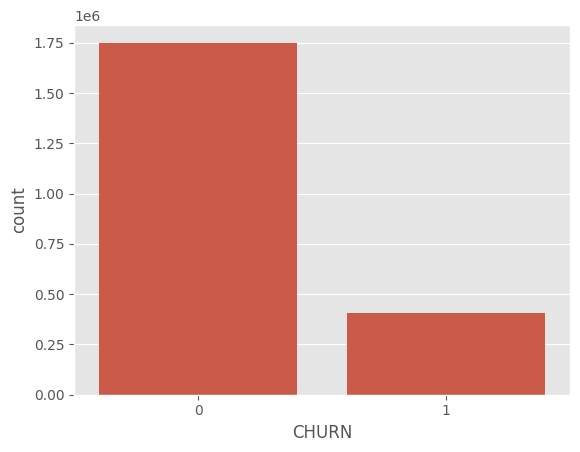

In [87]:
sns.countplot(data=df, x="CHURN")
plt.show()

## Data preprocessing

In [88]:
# Resampling

In [89]:
X = df.drop(["user_id", "MRG", "ZONE1", "ZONE2", "CHURN"], axis=1)
y = df.CHURN

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(X_train.shape)
print(X_test.shape)

(2046345, 14)
(107703, 14)


In [91]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        # Impute missing values in categorical columns and then apply one-hot encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols),
        # Impute missing values in numerical columns and then apply scaling
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols)
    ], remainder='passthrough')

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Model Training

### Traditional

In [92]:
xgb = XGBClassifier(n_estimators=100, subsample=0.8, colsample_bynode=0.8, n_jobs=-1)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [93]:
xgb.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.8,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [94]:
rf.fit(X_train_processed, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [95]:
y_pred_xgb = xgb.predict(X_test_processed)
xgb.score(X_test_processed, y_test)

0.8798919250160163

In [96]:
y_pred_rf = rf.predict(X_test_processed)
rf.score(X_test_processed, y_test)

0.8768000891340074

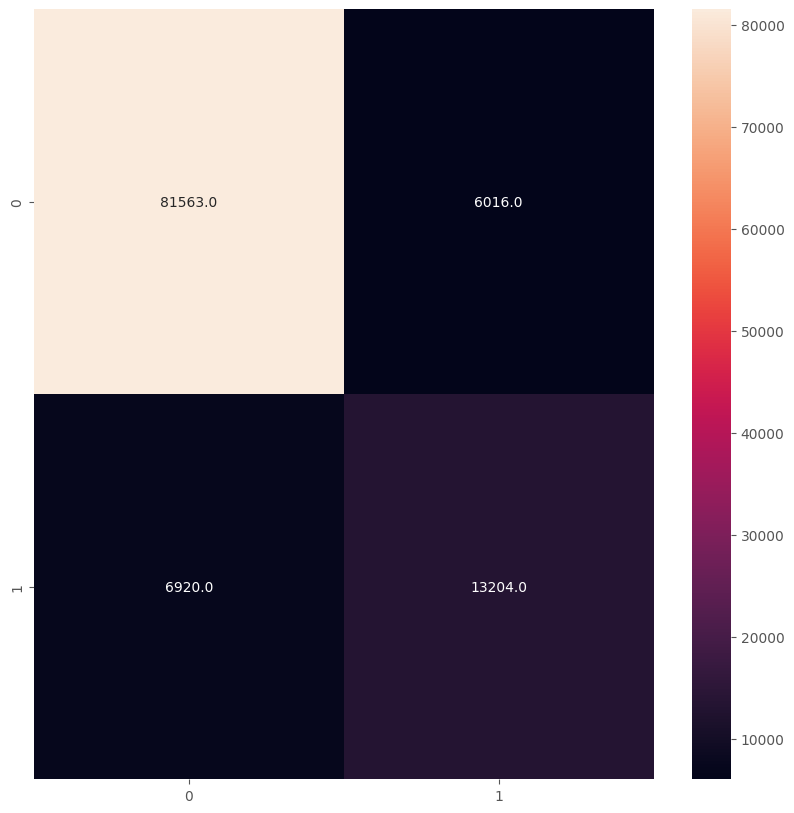

In [97]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='.1f')
plt.show()

In [98]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     87579
           1       0.69      0.66      0.67     20124

    accuracy                           0.88    107703
   macro avg       0.80      0.79      0.80    107703
weighted avg       0.88      0.88      0.88    107703



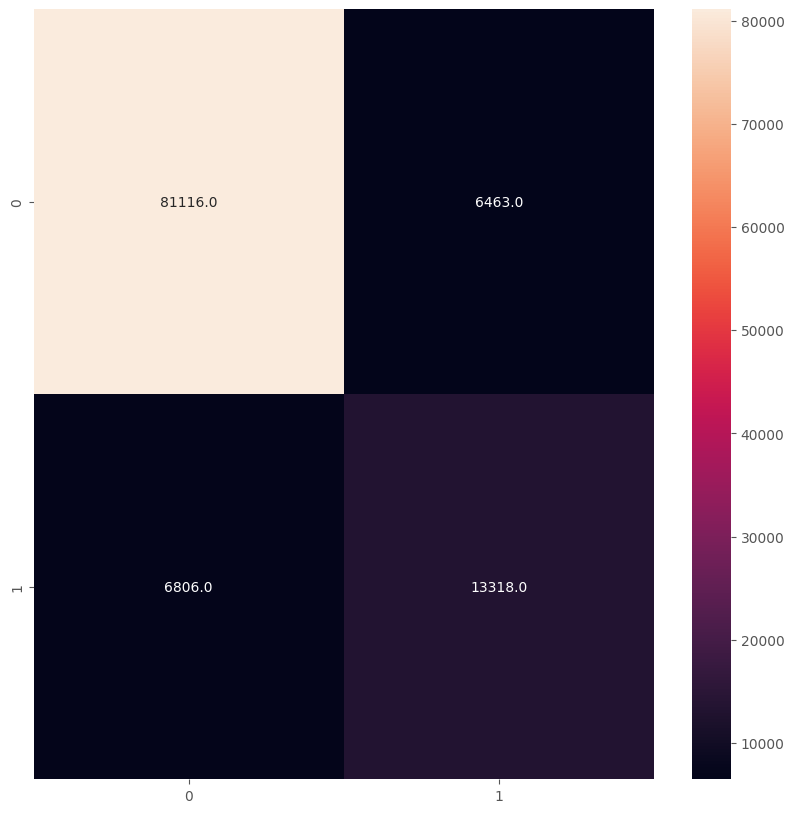

In [99]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='.1f')
plt.show()

In [100]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     87579
           1       0.67      0.66      0.67     20124

    accuracy                           0.88    107703
   macro avg       0.80      0.79      0.80    107703
weighted avg       0.88      0.88      0.88    107703



### Deep learning

In [101]:
dnn = Sequential()

# Input layer
dnn.add(Dense(256, input_dim=X_train_processed.shape[1], activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(BatchNormalization())

# Hidden layers
dnn.add(Dense(128, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(Dropout(0.3))  
dnn.add(BatchNormalization())

dnn.add(Dense(64, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(Dropout(0.3))  
dnn.add(BatchNormalization())

# Output layer
dnn.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

dnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 256)               45056     
                                                                 
 batch_normalization_12 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_13 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_29 (Dense)            (None, 64)              

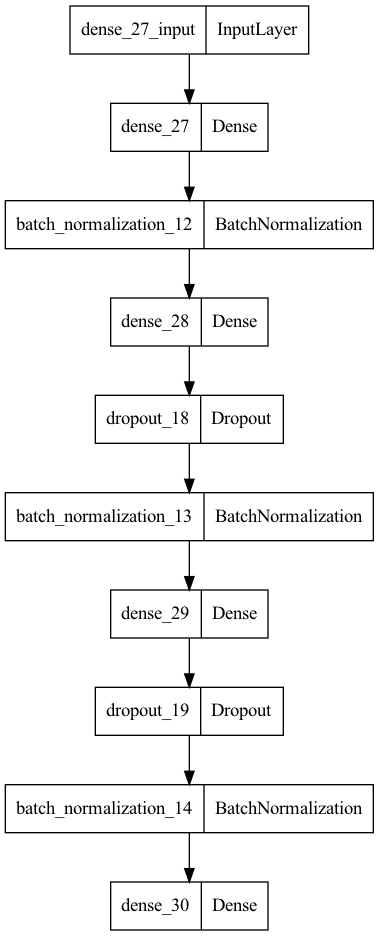

In [102]:
plot_model(dnn, to_file="../dnn.png")

In [103]:
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, clipvalue=0.5)
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [104]:
with tf.device('/cpu:0'):
    dnn.fit(X_train_processed, y_train, epochs=10, batch_size=64, validation_split=0.1) #validation_data=(X_test_processed, y_test))

Epoch 1/10
28777/28777 [==============================] - 44s 2ms/step - loss: 0.2883 - accuracy: 0.8729 - val_loss: 0.2623 - val_accuracy: 0.8773
Epoch 2/10
28777/28777 [==============================] - 40s 1ms/step - loss: 0.2708 - accuracy: 0.8745 - val_loss: 0.2641 - val_accuracy: 0.8755
Epoch 3/10
28777/28777 [==============================] - 39s 1ms/step - loss: 0.2691 - accuracy: 0.8753 - val_loss: 0.2626 - val_accuracy: 0.8752
Epoch 4/10
28777/28777 [==============================] - 38s 1ms/step - loss: 0.2685 - accuracy: 0.8755 - val_loss: 0.2615 - val_accuracy: 0.8770
Epoch 5/10
28777/28777 [==============================] - 39s 1ms/step - loss: 0.2685 - accuracy: 0.8756 - val_loss: 0.2636 - val_accuracy: 0.8762
Epoch 6/10
28777/28777 [==============================] - 52s 2ms/step - loss: 0.2683 - accuracy: 0.8754 - val_loss: 0.2630 - val_accuracy: 0.8756
Epoch 7/10
28777/28777 [==============================] - 46s 2ms/step - loss: 0.2684 - accuracy: 0.8756 - val_loss: 0

In [105]:
dnn.save("../models/dnn.h5")

In [106]:
loss, accuracy = dnn.evaluate(X_test_processed, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

3366/3366 [==============================] - 2s 455us/step - loss: 0.2593 - accuracy: 0.8781
Test Loss: 0.25931301712989807, Test Accuracy: 0.8781278133392334


test_1 = Sequential()
test_1.add(LSTM(8, return_sequences=True, input_shape=(X_train_processed.shape[1], 1)))
test_1.add(Activation(swish))
test_1.add(Dropout(0.2))
test_1.add(LSTM(8, return_sequences=True))
test_1.add(Dropout(0.2))
test_1.add(Activation(swish))
test_1.add(Dense(1, activation='sigmoid'))
test_1.summary()

test_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss and metrics as per your task
test_1.fit(X_train_processed, y_train, epochs=10, batch_size=64, validation_split=0.05)

In [152]:
rnn = Sequential()

rnn.add(SimpleRNN(4, return_sequences=True, input_shape=(X_train_processed.shape[1], 1)))
rnn.add(Activation(swish))
rnn.add(Dropout(0.2))

rnn.add(SimpleRNN(4, return_sequences=True))
rnn.add(Activation(swish))
rnn.add(Dropout(0.2))

# Output layer for binary classification
rnn.add(Dense(1, activation='sigmoid'))
rnn.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_24 (SimpleRNN)   (None, 175, 4)            24        
                                                                 
 activation_25 (Activation)  (None, 175, 4)            0         
                                                                 
 dropout_45 (Dropout)        (None, 175, 4)            0         
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 175, 4)            36        
                                                                 
 activation_26 (Activation)  (None, 175, 4)            0         
                                                                 
 dropout_46 (Dropout)        (None, 175, 4)            0         
                                                                 
 dense_47 (Dense)            (None, 175, 1)          

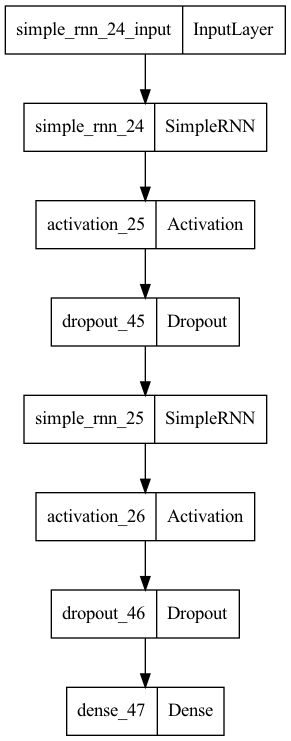

In [153]:
plot_model(rnn, to_file="../rnn.png")

In [154]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [155]:
rnn.fit(X_train_processed, y_train, epochs=10, batch_size=64, validation_split=0.05)

Epoch 1/10
30376/30376 [==============================] - 427s 14ms/step - loss: 0.4520 - accuracy: 0.8121 - val_loss: 0.4831 - val_accuracy: 0.8121
Epoch 2/10
30376/30376 [==============================] - 427s 14ms/step - loss: 0.4696 - accuracy: 0.8124 - val_loss: 0.4801 - val_accuracy: 0.8121
Epoch 3/10
30376/30376 [==============================] - 424s 14ms/step - loss: 0.4269 - accuracy: 0.8124 - val_loss: 0.4191 - val_accuracy: 0.8121
Epoch 4/10
30376/30376 [==============================] - 451s 15ms/step - loss: 0.4436 - accuracy: 0.8124 - val_loss: 0.4157 - val_accuracy: 0.8121
Epoch 5/10
30376/30376 [==============================] - 430s 14ms/step - loss: 0.4299 - accuracy: 0.8124 - val_loss: 0.4107 - val_accuracy: 0.8121
Epoch 6/10
30376/30376 [==============================] - 422s 14ms/step - loss: 0.4418 - accuracy: 0.8124 - val_loss: 0.4831 - val_accuracy: 0.8121
Epoch 7/10
30376/30376 [==============================] - 422s 14ms/step - loss: 0.4298 - accuracy: 0.8124

In [156]:
rnn.save("../models/rnn.h5")

In [ ]:
loss_2, accuracy_2 = rnn.evaluate(X_test_processed, y_test)
print(f"Test Loss: {loss_2}, Test Accuracy: {accuracy_2}")

In [145]:
input_dnn = Input(shape=(X_train_processed.shape[1],))
x_dnn = Dense(256, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(input_dnn)
x_dnn = BatchNormalization()(x_dnn)

x_dnn = Dense(128, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.3)(x_dnn)
x_dnn = BatchNormalization()(x_dnn)

x_dnn = Dense(64, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.3)(x_dnn)
x_dnn = BatchNormalization()(x_dnn)

input_rnn = Input(shape=(X_train_processed.shape[1], 1))
x_rnn = SimpleRNN(4, return_sequences=True)(input_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.2)(x_rnn)
x_rnn = BatchNormalization()(x_rnn)

# Set return_sequences=False in the last RNN layer
x_rnn = SimpleRNN(4, return_sequences=False)(x_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.2)(x_rnn)
x_rnn = BatchNormalization()(x_rnn)

combined = concatenate([x_dnn, x_rnn])

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(combined)

In [146]:
ensemble_model = Model(inputs=[input_dnn, input_rnn], outputs=output)
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 175)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 175, 1)]             0         []                            
                                                                                                  
 dense_43 (Dense)            (None, 256)                  45056     ['input_3[0][0]']             
                                                                                                  
 simple_rnn_22 (SimpleRNN)   (None, 175, 4)               24        ['input_4[0][0]']             
                                                                                              

In [147]:
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [148]:
ensemble_model.fit([X_train_processed, X_train_processed], y_train, epochs=10, batch_size=64, validation_split=0.05)

Epoch 1/10
30376/30376 [==============================] - 524s 17ms/step - loss: 0.2858 - accuracy: 0.8730 - val_loss: 0.2652 - val_accuracy: 0.8762
Epoch 2/10
30376/30376 [==============================] - 496s 16ms/step - loss: 0.2689 - accuracy: 0.8752 - val_loss: 0.2646 - val_accuracy: 0.8768
Epoch 3/10
30376/30376 [==============================] - 457s 15ms/step - loss: 0.2675 - accuracy: 0.8757 - val_loss: 0.2626 - val_accuracy: 0.8771
Epoch 4/10
30376/30376 [==============================] - 454s 15ms/step - loss: 0.2670 - accuracy: 0.8759 - val_loss: 0.2634 - val_accuracy: 0.8760
Epoch 5/10
30376/30376 [==============================] - 468s 15ms/step - loss: 0.2665 - accuracy: 0.8757 - val_loss: 0.2622 - val_accuracy: 0.8771
Epoch 6/10
30376/30376 [==============================] - 441s 15ms/step - loss: 0.2662 - accuracy: 0.8755 - val_loss: 0.2635 - val_accuracy: 0.8752
Epoch 7/10
30376/30376 [==============================] - 444s 15ms/step - loss: 0.2660 - accuracy: 0.8754

In [149]:
ensemble_model.save("../models/ensemble.h5")

In [151]:
loss_3, accuracy_3 = ensemble_model.evaluate([X_test_processed, X_test_processed], y_test)
print(f"Test Loss: {loss_3}, Test Accuracy: {accuracy_3}")

3366/3366 [==============================] - 11s 3ms/step - loss: 0.2591 - accuracy: 0.8786
Test Loss: 0.2590653598308563, Test Accuracy: 0.878582775592804
